## 1. Load Transactions & Define Snapshot
We load raw transactions and pick a snapshot date (defaults to the latest transaction) for consistent Recency calculation.

In [6]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data_processing import CreditRiskDataPipeline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Task 4: Proxy Target Variable Engineering

Create a binary target `is_high_risk` using RFM-driven clustering to proxy default risk when no ground-truth labels exist.

## 2. RFM Calculation
Compute Recency (days since last tx), Frequency (tx count), and Monetary (total value) per customer using the pipeline helper.

In [7]:
pipeline = CreditRiskDataPipeline()
df_raw = pipeline.load_transactions()
snapshot_date = df_raw['TransactionStartTime'].max()
print(f"Loaded {len(df_raw)} transactions; snapshot date = {snapshot_date.date()}")
df_raw.head()

rfm_df = pipeline.compute_rfm(df_raw)
rfm_df['snapshot_date'] = snapshot_date
print(rfm_df.describe())
rfm_df.head()

Loaded 95662 transactions; snapshot date = 2019-02-13
           Recency    Frequency      Monetary        snapshot_date
count  3742.000000  3742.000000  3.742000e+03                 3742
mean     30.461251    25.564404  2.531025e+05  2019-02-13 10:01:28
min       0.000000     1.000000  5.000000e+01  2019-02-13 10:01:28
25%       5.000000     2.000000  6.500000e+03  2019-02-13 10:01:28
50%      24.000000     7.000000  3.200000e+04  2019-02-13 10:01:28
75%      53.000000    20.000000  1.020600e+05  2019-02-13 10:01:28
max      90.000000  4091.000000  1.049000e+08  2019-02-13 10:01:28
std      27.118932    96.929602  2.715877e+06                  NaN


,CustomerId,Recency,Frequency,Monetary,snapshot_date
0,CustomerId_1,83,1,10000,2019-02-13 10:01:28
1,CustomerId_10,83,1,10000,2019-02-13 10:01:28
2,CustomerId_1001,89,5,30400,2019-02-13 10:01:28
3,CustomerId_1002,25,11,4775,2019-02-13 10:01:28
4,CustomerId_1003,11,6,32000,2019-02-13 10:01:28


## 3. Cluster Customers (K-Means, k=3)
Log-transform RFM to reduce skew, standardize, then cluster. Use `random_state=42` and `n_init=10` for reproducibility.

In [8]:
rfm_features = ['Recency', 'Frequency', 'Monetary']
X_log = np.log1p(rfm_df[rfm_features])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm_df['cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = rfm_df.groupby('cluster')[rfm_features].mean()
cluster_summary['count'] = rfm_df['cluster'].value_counts()
cluster_summary

,Recency,Frequency,Monetary,count
cluster,,,,
0,46.594458,2.261965,4482.056255,1191
1,4.263383,78.986081,801782.104925,934
2,33.710575,11.870748,119299.348176,1617


## 4. Define High-Risk Cluster & Label
Identify the least engaged cluster (high Recency, low Frequency/Monetary) and assign `is_high_risk`.

High-risk cluster: 0
           Recency  Frequency       Monetary  total_risk_score
cluster                                                       
0        46.594458   2.261965    4482.056255               9.0
1         4.263383  78.986081  801782.104925               3.0
2        33.710575  11.870748  119299.348176               6.0

High-risk share:
is_high_risk
0    0.681721
1    0.318279
Name: proportion, dtype: float64


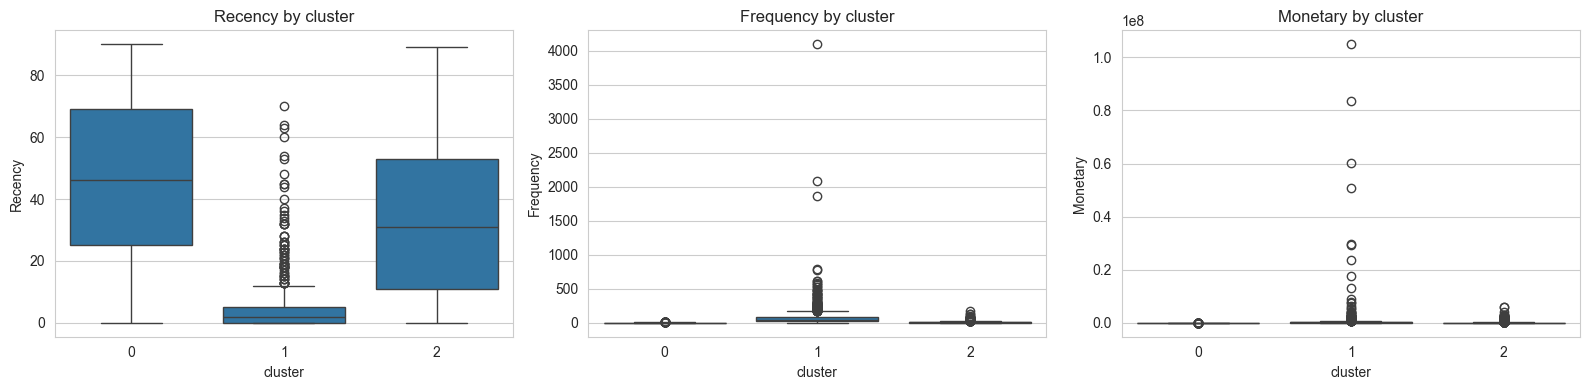

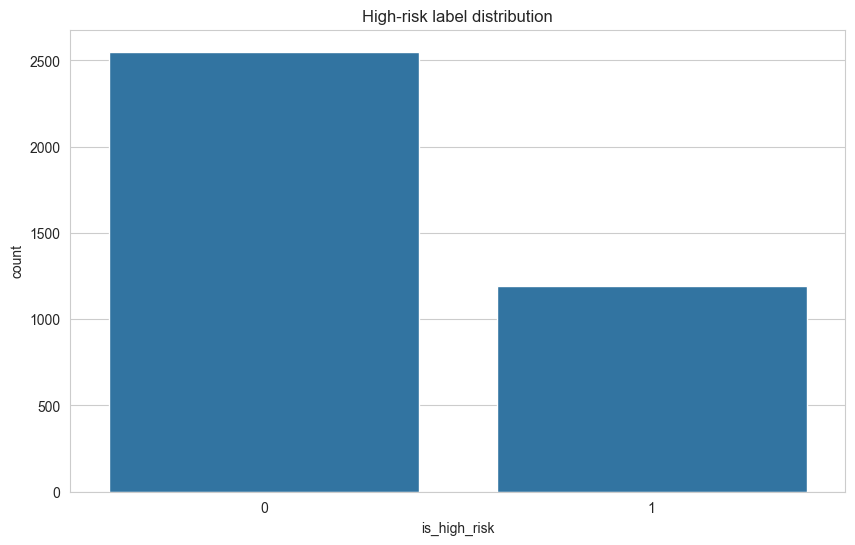

In [9]:
risk_profile = cluster_summary.copy()
risk_profile['R_rank'] = risk_profile['Recency'].rank(ascending=True)  # higher recency (days) is worse
risk_profile['F_rank'] = risk_profile['Frequency'].rank(ascending=False)
risk_profile['M_rank'] = risk_profile['Monetary'].rank(ascending=False)
risk_profile['total_risk_score'] = risk_profile[['R_rank', 'F_rank', 'M_rank']].sum(axis=1)
high_risk_cluster = risk_profile['total_risk_score'].idxmax()

rfm_df['is_high_risk'] = (rfm_df['cluster'] == high_risk_cluster).astype(int)
print(f"High-risk cluster: {high_risk_cluster}")
print(risk_profile[['Recency', 'Frequency', 'Monetary', 'total_risk_score']])

risk_dist = rfm_df['is_high_risk'].value_counts(normalize=True)
print("\nHigh-risk share:")
print(risk_dist)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.boxplot(x='cluster', y='Recency', data=rfm_df, ax=axes[0])
sns.boxplot(x='cluster', y='Frequency', data=rfm_df, ax=axes[1])
sns.boxplot(x='cluster', y='Monetary', data=rfm_df, ax=axes[2])
axes[0].set_title('Recency by cluster')
axes[1].set_title('Frequency by cluster')
axes[2].set_title('Monetary by cluster')
plt.tight_layout()
plt.show()

sns.countplot(x='is_high_risk', data=rfm_df)
plt.title('High-risk label distribution')
plt.show()

## 5. Integrate Target & Persist Artifacts
Merge the proxy label back into customer features and persist train/test artifacts for downstream modeling.

In [10]:
customer_features = pipeline.build_customer_features(df_raw)
assert 'is_high_risk' in customer_features.columns, "Label not found in features"

# Prepare feature matrix (encodes WoE, splits, scales) and persist artifacts
processed = pipeline.prepare_feature_matrix(customer_features)
pipeline.persist_artifacts(processed)

print("Saved artifacts to", pipeline.processed_dir)
print("Feature columns:", processed.feature_columns[:5], "... (total)", len(processed.feature_columns))
print("Train shape:", processed.X_train.shape, "Test shape:", processed.X_test.shape)
processed.customer_features.head()

Saved artifacts to C:\Users\alexo\Desktop\File\10Academy\week4\Github\Credit-Risk-Probability-Model-for-Alternative-Data\data\processed
Feature columns: ['Recency', 'Frequency', 'Monetary', 'total_amount', 'avg_amount'] ... (total) 26
Train shape: (2993, 26) Test shape: (749, 26)


,CustomerId,Recency,Frequency,Monetary,is_high_risk,total_amount,avg_amount,std_amount,min_amount,max_amount,...,transaction_hour_mean,transaction_day_mean,transaction_month_mean,transaction_year_mean,transaction_dayofweek_mean,weekend_transaction_ratio,primary_channel_woe,primary_category_woe,primary_currency_woe,primary_pricing_woe
0,CustomerId_1,83,1,10000,0,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,...,16.000000,21.000000,11.000000,2018.000000,2.000000,0.000000,0.431194,-0.843052,0.0,0.789635
1,CustomerId_10,83,1,10000,0,-10000.0,-10000.000000,0.000000,-10000.0,-10000.0,...,16.000000,21.000000,11.000000,2018.000000,2.000000,0.000000,0.431194,-0.843052,0.0,0.789635
2,CustomerId_1001,89,5,30400,0,20000.0,4000.000000,6558.963333,-5000.0,10000.0,...,7.800000,16.000000,11.000000,2018.000000,4.000000,0.000000,-0.337508,-0.309249,0.0,-0.387272
3,CustomerId_1002,25,11,4775,0,4225.0,384.090909,560.498966,-75.0,1500.0,...,13.454545,14.727273,8.636364,2018.272727,2.909091,0.181818,0.431194,-0.309249,0.0,-0.387272
4,CustomerId_1003,11,6,32000,0,20000.0,3333.333333,6030.478146,-5000.0,10000.0,...,14.333333,1.000000,2.000000,2019.000000,4.000000,0.000000,-0.337508,-0.843052,0.0,-0.387272
